<a href="https://colab.research.google.com/github/mithushank/FYP_Codes/blob/dev_autoencoder/AE_with_Sequence_decoder_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Libraries

In [1]:
#import libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.models import Model
from keras.models import Sequential,Model
from keras.layers import Dense
from tensorflow.keras.optimizers import Adam,SGD
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import MeanSquaredError
from tensorflow.keras.callbacks import Callback, TensorBoard, EarlyStopping
from IPython.display import clear_output
import datetime

import numpy as np
import math
import matplotlib.pyplot as plt
from scipy.signal import convolve

# variables

In [2]:
Number_channel_uses = 1 # it defines the number of symbols per messages. at a time one symbol can be transmitted

In [3]:
Eb_No = 10  # This should be a variable so that it can be used in the dictionary
from scipy.stats import truncnorm
from scipy.stats import uniform
channel_parameters = {
    "r"        : 4,                # For upsampling -> number of complex samples per symbol
    "Eb_No"    : Eb_No,            # Energy per bit to noise power spectral density ratio
    "roll_off" : 0.35,             # Roll off factor
    "num_taps" : 31,               # L -> Number of taps (odd) for RRC filter
    "f_s"      : 25e4,             # Sampling frequency
    "T_bound"  : 1/25e4,           # 1/f_s (symbol duration in seconds)
    "time_delay" : np.random.uniform(-1,1),  # Random time delay in the range [-1, 1]
    "CFO"      : 5e3,              # Carrier Frequency Offset in Hz
    "CFO_std"  : 5e3/25e4,         # Normalized Carrier Frequency Offset
    "noise_std": 10**(-1.0 * Eb_No / 10),  # Noise standard deviation, calculated from Eb_No
    "phase_off": uniform.rvs(scale=2*np.pi)  # Random phase offset in the range [0, 2π]
}

# stochasric channel layers

## stc for single message transmission

In [ ]:
class StochasticChannelv3(tf.keras.layers.Layer):
    def __init__(self, roll_off=0.35, num_taps=31, time_delay=2, r=4, ts=.5e-6, **kwargs):
        super(StochasticChannelv3, self).__init__(**kwargs)
        self.num_taps = num_taps
        self.time_delay = time_delay
        self.r = r  # Upsampling factor
        self.roll_off = roll_off  # Roll-off factor
        self.ts = ts  # Sampling period (default is 1)

    def upsampling(self, inp):
        com_reshape = tf.reshape(inp, [-1, 1])
        padding = tf.constant([[0, 0], [0, self.r - 1]])  # Access self.r
        upsampled = tf.pad(com_reshape, padding, mode="CONSTANT")
        upsampled = tf.reshape(upsampled, [-1])  # Flatten back to 1D
        print(upsampled.shape)
        return upsampled

    def upsample_iq(self, inp):
        real = inp[:, 0]  # Real part
        imag = inp[:, 1]  # Imaginary part

        real_up = self.upsampling(real)
        imag_up = self.upsampling(imag)

        upsampled = tf.stack([real_up, imag_up], axis=1)
        return upsampled

    def rrc_filter(self):
        t = np.linspace(-self.num_taps // 2, self.num_taps // 2 + 1, self.num_taps) - self.time_offset()
        rrc = np.zeros_like(t)

        for i in range(len(t)):
            if t[i] == 0.0:
                rrc[i] = (1.0 - self.roll_off + 4 * self.roll_off / np.pi) / self.ts
            elif np.abs(t[i]) == self.ts / (4 * self.roll_off):
                rrc[i] = (self.roll_off / (np.sqrt(2) * self.ts)) * \
                         ((1 + 2 / np.pi) * np.sin(np.pi / (4 * self.roll_off)) +
                          (1 - 2 / np.pi) * np.cos(np.pi / (4 * self.roll_off)))
            else:
                rrc[i] = (np.sin(np.pi * (t[i] / self.ts) * (1 - self.roll_off)) +
                          4 * self.roll_off * (t[i] / self.ts) * np.cos(np.pi * (t[i] / self.ts) * (1 + self.roll_off))) / \
                         (np.pi * t[i] * (1 - (4 * self.roll_off * (t[i] / self.ts)) ** 2))

        rrc = rrc / np.sqrt(np.sum(rrc ** 2))
        rrc = tf.constant(rrc, dtype=tf.float32)
        return rrc

    def upsample_and_filter(self, signal):
        upsampled_signal = self.upsample_iq(signal)
        rrc = self.rrc_filter()

        upsampled_signal = tf.expand_dims(upsampled_signal, axis=0)  # Shape: (1, length, 2)
        rrc = tf.reshape(rrc, [-1, 1, 1])  # Shape: (filter_length, 1, 1)

        padding_size = self.num_taps // 2
        paddings = tf.constant([[0, 0], [padding_size, padding_size], [0, 0]])
        padded_real = tf.pad(upsampled_signal[:, :, 0:1], paddings, "CONSTANT")
        padded_imag = tf.pad(upsampled_signal[:, :, 1:2], paddings, "CONSTANT")
        upsampled_signal = tf.concat([padded_real, padded_imag], axis=2)
        real_filtered = tf.nn.conv1d(upsampled_signal[:, :, 0:1], rrc, stride=1, padding='SAME')
        imag_filtered = tf.nn.conv1d(upsampled_signal[:, :, 1:2], rrc, stride=1, padding='SAME')

        filtered_signal = tf.concat([real_filtered, imag_filtered], axis=2)
        filtered_signal = tf.squeeze(filtered_signal, axis=0)  # Remove the batch dimension
        return filtered_signal

    def time_offset(self, sampling_time=10):
        t_offset = np.random.uniform(-sampling_time // 2, sampling_time // 2)
        return t_offset

    def call(self, inputs):
        batch_size = tf.shape(inputs)[0]
        f = inputs.shape[1] // 2

        # Reshape to pairs of real and imaginary parts
        inputs = tf.reshape(inputs, [batch_size, -1, 2])  # Shape: (batch_size, num_pairs, 2)

        # Define a function to process each sample
        def process_sample(sample):
            filtered_signal = self.upsample_and_filter(sample)  # Process each sample
            return filtered_signal

        # Apply the function to each sample in the batch
        output = tf.map_fn(process_sample, inputs, dtype=tf.float32)  # Shape: (batch_size, num_filtered_samples, 2)

        # Reshape back to original shape if necessary
        output = tf.reshape(output, [batch_size, -1])

        return output

## stc for cts transmission

In [5]:
  """
  When using this make sure that batch size is divisible by 2*l+1
  """
class StochasticChannelv3_cts_tr(tf.keras.layers.Layer):

    def __init__(self, roll_off=0.35, num_taps=31, time_delay=2, r=4, ts=.5e-6,l = 6, **kwargs):
        super(StochasticChannelv3_cts_tr, self).__init__(**kwargs)
        self.num_taps = num_taps
        self.time_delay = time_delay
        self.r = r  # Upsampling factor
        self.roll_off = roll_off  # Roll-off factor
        self.ts = ts  # Sampling period (default is 1)
        self.l = l

    def upsampling(self, inp):
        com_reshape = tf.reshape(inp, [-1, 1])
        padding = tf.constant([[0, 0], [0, self.r - 1]])  # Access self.r
        upsampled = tf.pad(com_reshape, padding, mode="CONSTANT")
        upsampled = tf.reshape(upsampled, [-1])  # Flatten back to 1D
        return upsampled

    def upsample_iq(self, inp):
        real = inp[:, 0]  # Real part
        imag = inp[:, 1]  # Imaginary part

        real_up = self.upsampling(real)
        imag_up = self.upsampling(imag)
        upsampled = tf.stack([real_up, imag_up], axis=1)
        return upsampled

    def rrc_filter(self):
        print("time offset for this task", self.time_offset())
        t = np.linspace(-self.num_taps // 2, self.num_taps // 2 + 1, self.num_taps) - self.time_offset()
        rrc = np.zeros_like(t)

        for i in range(len(t)):
            if t[i] == 0.0:
                rrc[i] = (1.0 - self.roll_off + 4 * self.roll_off / np.pi) / self.ts
            elif np.abs(t[i]) == self.ts / (4 * self.roll_off):
                rrc[i] = (self.roll_off / (np.sqrt(2) * self.ts)) * \
                         ((1 + 2 / np.pi) * np.sin(np.pi / (4 * self.roll_off)) +
                          (1 - 2 / np.pi) * np.cos(np.pi / (4 * self.roll_off)))
            else:
                rrc[i] = (np.sin(np.pi * (t[i] / self.ts) * (1 - self.roll_off)) +
                          4 * self.roll_off * (t[i] / self.ts) * np.cos(np.pi * (t[i] / self.ts) * (1 + self.roll_off))) / \
                         (np.pi * t[i] * (1 - (4 * self.roll_off * (t[i] / self.ts)) ** 2))

        rrc = rrc / np.sqrt(np.sum(rrc ** 2))
        rrc = tf.constant(rrc, dtype=tf.float32)
        return rrc

    def upsample_and_filter(self, signal):
        upsampled_signal = self.upsample_iq(signal)
        rrc = self.rrc_filter()


        upsampled_signal = tf.expand_dims(upsampled_signal, axis=0)  # Shape: (1, length, 2)
        rrc = tf.reshape(rrc, [-1, 1, 1])  # Shape: (filter_length, 1, 1)

        padding_size = self.num_taps // 2
        paddings = tf.constant([[0, 0], [padding_size, padding_size], [0, 0]])
        padded_real = tf.pad(upsampled_signal[:, :, 0:1], paddings, "CONSTANT")
        padded_imag = tf.pad(upsampled_signal[:, :, 1:2], paddings, "CONSTANT")
        upsampled_signal = tf.concat([padded_real, padded_imag], axis=2)
        real_filtered = tf.nn.conv1d(upsampled_signal[:, :, 0:1], rrc, stride=1, padding='SAME')
        imag_filtered = tf.nn.conv1d(upsampled_signal[:, :, 1:2], rrc, stride=1, padding='SAME')

        filtered_signal = tf.concat([real_filtered, imag_filtered], axis=2)
        filtered_signal = tf.squeeze(filtered_signal, axis=0)  # Remove the batch dimension
        return filtered_signal

    def time_offset(self, sampling_time=10):
        t_offset = np.random.uniform(-sampling_time // 2, sampling_time // 2)
        return 0

    def call(self, inputs):
        batch_size = tf.shape(inputs)[0]
        f = inputs.shape[1] // 2
        beta = batch_size//(2*self.l+1)
        out= []
        for i in range(beta):
          x = inputs[(2*self.l+1)*i:(2*self.l+1)*(i+1)]
          # c = tf.concat(tf.unstack(x, axis=1), axis=0)  # Unstack along axis=1 and concatenate
          out.append(x)
        inputs = tf.stack(out, axis=0)

        # Reshape to pairs of real and imaginary parts
        inputs = tf.reshape(inputs, [batch_size//(2*self.l+1), -1, 2])  # Shape: (batch_size, num_pairs, 2)


        # Define a function to process each sample
        def process_sample(sample):
            filtered_signal = self.upsample_and_filter(sample)  # Process each sample
            return filtered_signal

        # Apply the function to each sample in the batch
        output = tf.map_fn(process_sample, inputs, dtype=tf.float32)  # Shape: (batch_size, num_filtered_samples, 2)

        # Reshape back to original shape if necessary
        output = tf.reshape(output, [batch_size//(2*self.l+1), -1])

        return output

    # def call(self, inputs):
    #     batch_size = tf.shape(inputs)[0]
    #     group_size = 2 * self.l + 1  # Define the group size

    #     # Reshape inputs into groups of (2 * l + 1)
    #     # This creates a tensor of shape (beta, group_size, input_dim)
    #     beta = batch_size // group_size
    #     # inputs = tf.reshape(inputs, [beta, group_size, -1])  # Reshape without a for loop
    #     print('input shape before the sub grpups ',inputs.shape)
    #     # Reshape to pairs of real and imaginary parts
    #     inputs = tf.reshape(inputs, [beta, -1, 2])  # Shape: (batch_size, num_pairs, 2)

    #     # need to create the window

    #     # Define a function to process each sample
    #     def process_sample(sample):
    #         filtered_signal = self.upsample_and_filter(sample)  # Process each sample
    #         return filtered_signal

    #     # Apply the function to each sample in the batch using tf.map_fn
    #     output = tf.map_fn(process_sample, inputs, dtype=tf.float32)


    #     # Reshape back to original shape if necessary
    #     output = tf.reshape(output, [beta, -1])
    #     print('output shape after do the sub group', output.shape)

    #     # # include slidcer to the model
    #     # k1 = self.r * 4 + (self.num_taps + 1) // 2
    #     # k2 = 2 * self.l * self.r * 4 + (self.num_taps - 1) // 2
    #     # seq_len = k2 - k1 + 1
    #     # print(f"k1: {k1}, k2: {k2}, seq_len: {seq_len}")
    #     # output = output[:, k1:(k2+1)]
    #     # print(output.shape)

    #     return output

    def call(self, inputs,return_offset=False):
        batch_size = tf.shape(inputs)[0]
        input_dim = tf.shape(inputs)[1]

        # Ensure group_size divides batch_size evenly
        group_size = 2 * self.l + 1  # e.g., 13
        # if batch_size % group_size != 0:
        #     raise ValueError(f"Batch size ({batch_size}) must be divisible by group size ({group_size}).")

        # Reshape inputs into groups without changing the batch size
        num_groups = batch_size // group_size
        inputs = tf.reshape(inputs, [num_groups, group_size, input_dim])

        # Merge group_size into the features dimension
        inputs = tf.reshape(inputs, [batch_size // group_size, group_size * input_dim])

        # Reshape to pairs of real and imaginary parts
        inputs = tf.reshape(inputs, [batch_size // group_size, -1, 2])

        # Define a function to process each sample
        def process_sample(sample):
            filtered_signal = self.upsample_and_filter(sample)
            return filtered_signal

        # Apply the function to each sample in the batch using tf.map_fn
        output = tf.map_fn(process_sample, inputs, dtype=tf.float32)

        # Reshape back to original batch size
        output = tf.reshape(output, [batch_size // group_size, -1])

        # Expand the output to match the original batch size
        output = tf.tile(output, [group_size, 1])
        print(output.shape)
        batch_time_offset = self.time_offset()
        # include slidcer to the model
        k1 = self.r * 4 + (self.num_taps + 1) // 2
        k2 = 2 * self.l * self.r * 4 + (self.num_taps - 1) // 2
        seq_len = k2 - k1 + 1
        print(f"k1: {k1}, k2: {k2}, seq_len: {seq_len}")
        in_dim = output.shape[1]

        output_1 = output[:, k1-1:k2]
        output_2 = output[:, in_dim//2+k1-1:in_dim//2+k2]
        print(output_1.shape)
        print(output_2.shape)
        output = tf.concat([output_1, output_2],axis = 1)
        print(output.shape)
        if return_offset:
            # If we need to return the time offset (for training the offset estimator)
            return output, batch_time_offset
        else:
            # If we're just passing through the autoencoder
            return output
        return output



# Sequence Decoder

In [6]:
import tensorflow as tf
from tensorflow.keras.layers import Dense
from tensorflow.keras import Sequential

class SD(tf.keras.layers.Layer):
    def __init__(self, l=6, n=4, r=4, **kwargs):
        super(SD, self).__init__(**kwargs)
        self.l = l
        self.n = n
        self.r = r

        with tf.name_scope("fe"):
            self.fe = Sequential([
                Dense(256, activation='relu', name='initial'),
                Dense(8, activation='linear', name='feature_extractor')
            ])

        with tf.name_scope("pe"):
            self.pe = Sequential([
                Dense(256, activation='relu', name='initial'),
                Dense(2, activation='linear', name='phase_estimator')
            ])

    def mini_slicer(self, inputs):
        in_dim = tf.shape(inputs)[1]
        N_msg = self.r * self.n
        l1 = 1 + (self.l - 1) * N_msg - self.r
        l2 = self.l * N_msg + self.r
        out_1 = inputs[:, l1-1:l2]
        out_2 = inputs[:, in_dim // 2 + l1-1:in_dim // 2 + l2]
        output = tf.concat([out_1, out_2], axis=1)
        print('mini slice output shape', output.shape)
        return output

    def call(self, inputs):
        # Get the input dimension (before slicing)
        in_dim = inputs.shape[1]

        # Process the inputs using mini_slicer (this changes the shape of inputs)
        inputs = self.mini_slicer(inputs)

        # Update real and imag slices based on new input shape (after mini_slicer)
        half_dim = tf.shape(inputs)[1] // 2  # Get new half dimension after slicing
        real = inputs[:, :half_dim]  # First half of sliced inputs as real part
        imag = inputs[:, half_dim:]  # Second half as imaginary part

        # Pass the sliced inputs to the phase estimator model to get h
        h = self.pe(inputs)  # h has shape (batch_size, 2)
        h_real = h[:, 0]  # Extract real part of h
        h_imag = h[:, 1]  # Extract imaginary part of h

        h_real = tf.expand_dims(h_real, axis=1)
        h_imag = tf.expand_dims(h_imag, axis=1)

        # Perform element-wise multiplication
        h_real_ex = tf.tile(h_real, [1, half_dim])
        h_imag_ex = tf.tile(h_imag, [1, half_dim])
        real_mul = real * h_real_ex  # Multiply same value of real part to every component of the input
        imag_mul = imag * h_imag_ex

        # Apply the feature extractor model to real_mul (as an example)
        feature_extract_output = self.fe(inputs)

        # Concatenate the outputs
        output = tf.concat([real_mul, imag_mul, feature_extract_output], axis=1)

        return output


## test for seq_decoder

In [ ]:
small = Model(inputs = autoencoder_model[0].get_layer('Input').input, outputs = autoencoder_model[0].get_layer('stc').output)
enc = small(test_dataset[:13*12])
out_sd = SD()
out = out_sd(enc)
print(out.shape)

 Normalize each input power to 1,shape  (156, 8)
time offset for this task 3
time offset for this task 3
time offset for this task 3
time offset for this task 3
time offset for this task 3
time offset for this task 3
time offset for this task 3
time offset for this task 3
time offset for this task 3
time offset for this task 3
time offset for this task 3
time offset for this task 3
(156, 476)
k1: 32, k2: 207, seq_len: 176
(156, 176)
(156, 176)
(156, 352)
mini slice output shape (156, 48)
mini slice output shape (156, 48)
(156, 56)


# Final Auto encoder combine with stc and sequence decoder

## Model with training

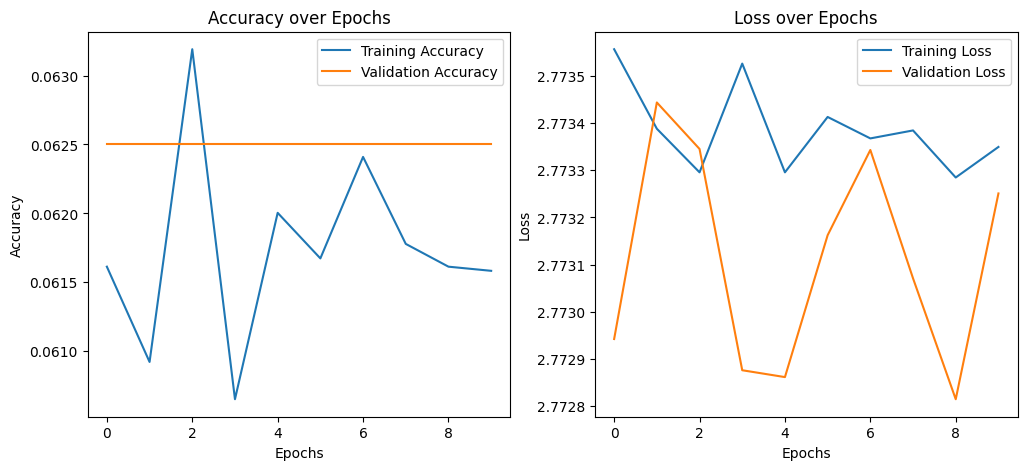

320/320 ━━━━━━━━━━━━━━━━━━━━ 8s 24ms/step - accuracy: 0.0619 - loss: 2.7733 - val_accuracy: 0.0625 - val_loss: 2.7733


In [7]:


# Dataset Parameters
N = 4  # Number of channel uses
M = 16  # Number of total messages that can be transmitted
K = int(math.ceil(np.log2(M)))  # Block size
l = 6
Eb_No = 10
batch_size = (2*l+1)*320

# Create Dataset in one-hot vector
alphabet_size = pow(2, K)
alphabet = np.eye(alphabet_size, dtype='float32')

train_dataset = np.tile(alphabet, (batch_size, 1))
test_dataset = np.tile(alphabet, (batch_size * 10, 1))

# Custom Callback for Real-time Plotting
class PlottingCallback(Callback):
    def __init__(self):
        super(PlottingCallback, self).__init__()
        self.history = {'accuracy': [], 'val_accuracy': [], 'loss': [], 'val_loss': []}

    def on_epoch_end(self, epoch, logs=None):
        # Update history
        self.history['accuracy'].append(logs.get('accuracy'))
        self.history['val_accuracy'].append(logs.get('val_accuracy'))
        self.history['loss'].append(logs.get('loss'))
        self.history['val_loss'].append(logs.get('val_loss'))

        # Clear previous output
        clear_output(wait=True)

        # Plot training and validation accuracy
        plt.figure(figsize=(12, 5))

        plt.subplot(1, 2, 1)
        plt.plot(self.history['accuracy'], label='Training Accuracy')
        plt.plot(self.history['val_accuracy'], label='Validation Accuracy')
        plt.title('Accuracy over Epochs')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.legend()

        # Plot training and validation loss
        plt.subplot(1, 2, 2)
        plt.plot(self.history['loss'], label='Training Loss')
        plt.plot(self.history['val_loss'], label='Validation Loss')
        plt.title('Loss over Epochs')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()

        plt.show()

# Normalization Layer
class Normalization(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(Normalization, self).__init__(**kwargs)

    def call(self, input):
        shape = tf.shape(input)
        out = tf.nn.l2_normalize(tf.reshape(input, (-1, 2)), axis=-1, epsilon=1e-5)
        out = tf.reshape(out, (-1,2*N))
        print(" Normalize each input power to 1,shape ",out.shape)
        return out

    def get_config(self):
        return super(Normalization, self).get_config()

# Custom Noise Layer
class CustomNoise(tf.keras.layers.Layer):
    def __init__(self, mean=0.0, stddev=10**(-1.0*Eb_No), **kwargs):
        super(CustomNoise, self).__init__(**kwargs)
        self.mean = mean
        self.stddev = stddev

    def call(self, inputs):
        noise = tf.random.normal(shape=tf.shape(inputs), mean=self.mean, stddev=self.stddev)
        return inputs + noise

import tensorflow as tf
from tensorflow.keras.layers import Layer

class AE:
    def __init__(self, train_data=train_dataset, test_data=test_dataset, input_dim=K, enc_dim=N, act_fun='tanh'):
        self.train_data = train_data
        self.test_data = test_data
        self.input_dim = input_dim
        self.enc_dim = enc_dim
        self.act_fun = act_fun

    def AE_implement(self):
        autoencoder = Sequential([
            Dense(2**(self.input_dim), activation=self.act_fun, name="Input"),
            Dense(2**(self.input_dim), activation=self.act_fun, name="encoder"),
            Dense(2**(self.input_dim), activation=self.act_fun, name="middle1"),
            Dense(self.enc_dim * 2, activation=self.act_fun, name='middle2'),

            # Normalization Layer
            Normalization(name = 'normalization'),

            # Channel Layer
            StochasticChannelv3_cts_tr(name = 'stc'),
            # NormalizedRRCFilterLayer( ),
            CustomNoise(name = 'noise'),
            SD(name = 'sd'),
            # CustomNoise(

            # Decoder layers
            Dense(self.enc_dim * 4, activation=self.act_fun, name="decoder1"),
            Dense(2**(self.input_dim), activation=self.act_fun, name='decoder2'),
            Dense(2**(self.input_dim), activation='softmax', name='Output')
        ])

        autoencoder.compile(optimizer=Adam(learning_rate=1e-2), loss='categorical_crossentropy',metrics=['accuracy'])
        return autoencoder

    def train(self, epochs=20, batch_size=64):
        autoencoder = self.AE_implement()
        # autoencoder.fit(self.train_data, self.train_data,
        #                 epochs=epochs, batch_size=batch_size,
        #                 validation_data=(self.test_data, self.test_data))
        # # return autoencoder

        # TensorBoard setup
        log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
        tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)
        print(self.test_data.shape)

        history = autoencoder.fit(self.train_data, self.train_data,
                                  epochs=epochs, batch_size=(2*l+1)*16,
                                  validation_data=(self.test_data, self.test_data),
                                  callbacks=[PlottingCallback(), tensorboard_callback])
        return autoencoder, history

# Instantiate the AE class and train the model
ae = AE(train_data=train_dataset[:], test_data=test_dataset[:16*13], input_dim=K, enc_dim=N, act_fun='relu')
autoencoder_model = ae.train(epochs=10, batch_size=(2*l+1))


## view in tensor board

In [ ]:
%reload_ext tensorboard
%load_ext tensorboard
%tensorboard --logdir logs/fit

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Launching TensorBoard...

KeyboardInterrupt: 

## plots of the output

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming you have your input and output from the autoencoder
# Example:
# input_data = your_input_data   # Shape (156, 16)
# output_data = autoencoder.predict(your_input_data)  # Shape (156, 16)

def plot_autoencoder_performance(input_data, output_data, num_samples=5):
    # Ensure the number of samples to plot does not exceed the number of available samples
    num_samples = min(num_samples, input_data.shape[0])

    # Create subplots
    fig, axs = plt.subplots(num_samples, 2, figsize=(10, num_samples * 3))
    fig.suptitle('Autoencoder Input vs Output', fontsize=16)

    for i in range(num_samples):
        # Plot input data (original data)
        axs[i, 0].plot(input_data[i], color='blue')
        axs[i, 0].set_title(f"Input {i+1}")

        # Plot output data (reconstructed data)
        axs[i, 1].plot(output_data[i], color='red')
        axs[i, 1].set_title(f"Output {i+1}")

        # Adding labels
        axs[i, 0].set_ylabel('Amplitude')
        axs[i, 1].set_ylabel('Amplitude')

    # Adding x-axis labels
    axs[-1, 0].set_xlabel('Feature Index')
    axs[-1, 1].set_xlabel('Feature Index')

    plt.tight_layout()
    plt.subplots_adjust(top=0.93)  # Adjust for title
    plt.show()




NameError: name 'test_dataset' is not defined

## plots of constellations for output

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming you have your input and output from the autoencoder
# Example:
# input_data = your_input_data   # Shape (156, 16)
# output_data = autoencoder.predict(your_input_data)  # Shape (156, 16)

def plot_constellation(input_data, output_data, num_samples=5):
    # Ensure the number of samples to plot does not exceed the number of available samples
    num_samples = min(num_samples, input_data.shape[0])

    # Create subplots for constellation
    fig, axs = plt.subplots(num_samples, 2, figsize=(10, num_samples * 5))
    fig.suptitle('Autoencoder Input vs Output Constellation', fontsize=16)

    for i in range(num_samples):
        # Extract real and imaginary parts for input and output
        input_real = input_data[i, ::2]   # Real parts from even indices
        input_imag = input_data[i, 1::2]  # Imaginary parts from odd indices
        output_real = output_data[i, ::2]  # Real parts from even indices
        output_imag = output_data[i, 1::2]  # Imaginary parts from odd indices

        # Plot input constellation
        axs[i, 0].scatter(input_real, input_imag, color='blue', s=50, label='Input')
        axs[i, 0].set_title(f"Input Constellation {i+1}")
        axs[i, 0].set_xlabel('Real')
        axs[i, 0].set_ylabel('Imaginary')
        axs[i, 0].grid(True)

        # Plot output constellation
        axs[i, 1].scatter(output_real, output_imag, color='red', s=50, label='Output')
        axs[i, 1].set_title(f"Output Constellation {i+1}")
        axs[i, 1].set_xlabel('Real')
        axs[i, 1].set_ylabel('Imaginary')
        axs[i, 1].grid(True)

    plt.tight_layout()
    plt.subplots_adjust(top=0.93)  # Adjust for title
    plt.show()




In [ ]:
autoencoder_model[0].summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ Input (Dense)                        │ (208, 16)                   │             272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ encoder (Dense)                      │ (208, 16)                   │             272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ middle1 (Dense)                      │ (208, 16)                   │             272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ middle2 (Dense)                      │ (208, 8)                    │             136 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ normalization (Normalization)        │ (208, 8)                    │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ stc (StochasticChannelv3_cts_tr)     │ (208, 352)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ noise (CustomNoise)                  │ (208, 352)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ decoder1 (Dense)                     │ (208, 16)                   │           5,648 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ decoder2 (Dense)                     │ (208, 16)                   │             272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Output (Dense)                       │ (208, 16)                   │             272 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 21,434 (83.73 KB)

 Trainable params: 7,144 (27.91 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 14,290 (55.82 KB)